In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import numpy as np
import py21cmfast as p21c
import h5py
import powerbox
from scipy import interpolate
from tqdm import tqdm

WDIR = os.environ['DM21CM_DIR']
sys.path.append(WDIR)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colormaps as cms
mpl.rc_file(f"{WDIR}/matplotlibrc")

/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/py21cmfast/_cfg.py:58: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn(
/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/py21cmfast/_cfg.py:42: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn("Your configuration file is out of date. Updating...")


In [7]:
outputs_dir = "/n/holylabs/LABS/iaifi_lab/Users/yitians/dm21cm/outputs"

bkg_fn = f"{outputs_dir}/bkg/LightCones/LightCone_z5.0_HIIDIM=128_BOXLEN=256_fisher_fid_r54321.h5"
inj_0_fn = f"{outputs_dir}/decay/phot/Mass3/LightCone_z5.0_HIIDIM=128_BOXLEN=256_fisher_DM_2_r54321.h5"
inj_1_fn = f"{outputs_dir}/decay/phot_hom/Mass3/LightCone_z5.0_HIIDIM=128_BOXLEN=256_fisher_DM_2_r54321.h5"

In [8]:
lc_bkg = p21c.LightCone.read(bkg_fn)
lc_0 = p21c.LightCone.read(inj_0_fn)
lc_1 = p21c.LightCone.read(inj_1_fn)

In [9]:
import powerbox as pbox

def compute_power(
   box,
   length,
   n_psbins,
   log_bins=True,
   ignore_kperp_zero=True,
   ignore_kpar_zero=False,
   ignore_k_zero=False,
):
    # Determine the weighting function required from ignoring k's.
    k_weights = np.ones(box.shape, int)
    n0 = k_weights.shape[0]
    n1 = k_weights.shape[-1]

    if ignore_kperp_zero:
        k_weights[n0 // 2, n0 // 2, :] = 0
    if ignore_kpar_zero:
        k_weights[:, :, n1 // 2] = 0
    if ignore_k_zero:
        k_weights[n0 // 2, n0 // 2, n1 // 2] = 0

    res = pbox.tools.get_power(
        box,
        boxlength=length,
        bins=n_psbins,
        bin_ave=False,
        get_variance=False,
        log_bins=log_bins,
        k_weights=k_weights,
    )

    res = list(res)
    k = res[1]
    if log_bins:
        k = np.exp((np.log(k[1:]) + np.log(k[:-1])) / 2)
    else:
        k = (k[1:] + k[:-1]) / 2

    res[1] = k
    return res

BOX_LEN = 256 # [Mpc]

def powerspectra(brightness_temp, z_start, z_end, n_psbins=30, logk=True):
    lightcone_redshifts = brightness_temp.lightcone_redshifts
    i_start = np.argmin(np.abs(lightcone_redshifts - z_start))
    i_end = np.argmin(np.abs(lightcone_redshifts - z_end))

    chunklen = (i_end - i_start) * brightness_temp.cell_size

    power, k = compute_power(
        brightness_temp.brightness_temp[:, :, i_start:i_end],
        (BOX_LEN, BOX_LEN, chunklen),
        n_psbins,
        log_bins=logk,
    )
    return {
        "k": k,
        "delta": power * k ** 3 / (2 * np.pi ** 2)
    }

In [10]:
ps_bkg_s = []
ps_0_s = []
ps_1_s = []
z_start_s = np.linspace(5, 23, 10)

for i, ax in enumerate(tqdm(range(10))):
    z_start = z_start_s[i]
    z_end = z_start + 2

    ps_bkg_s.append(powerspectra(lc_bkg, z_start, z_end, n_psbins=30))
    ps_0_s.append(powerspectra(lc_0, z_start, z_end, n_psbins=30))
    ps_1_s.append(powerspectra(lc_1, z_start, z_end, n_psbins=30))

  0%|          | 0/10 [00:00<?, ?it/s]/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/powerbox/tools.py:325: UserWarning: One or more radial bins had no cells within it.
  return angular_average(
/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/powerbox/tools.py:180: RuntimeWarning: invalid value encountered in divide
  np.bincount(
100%|██████████| 10/10 [03:43<00:00, 22.37s/it]


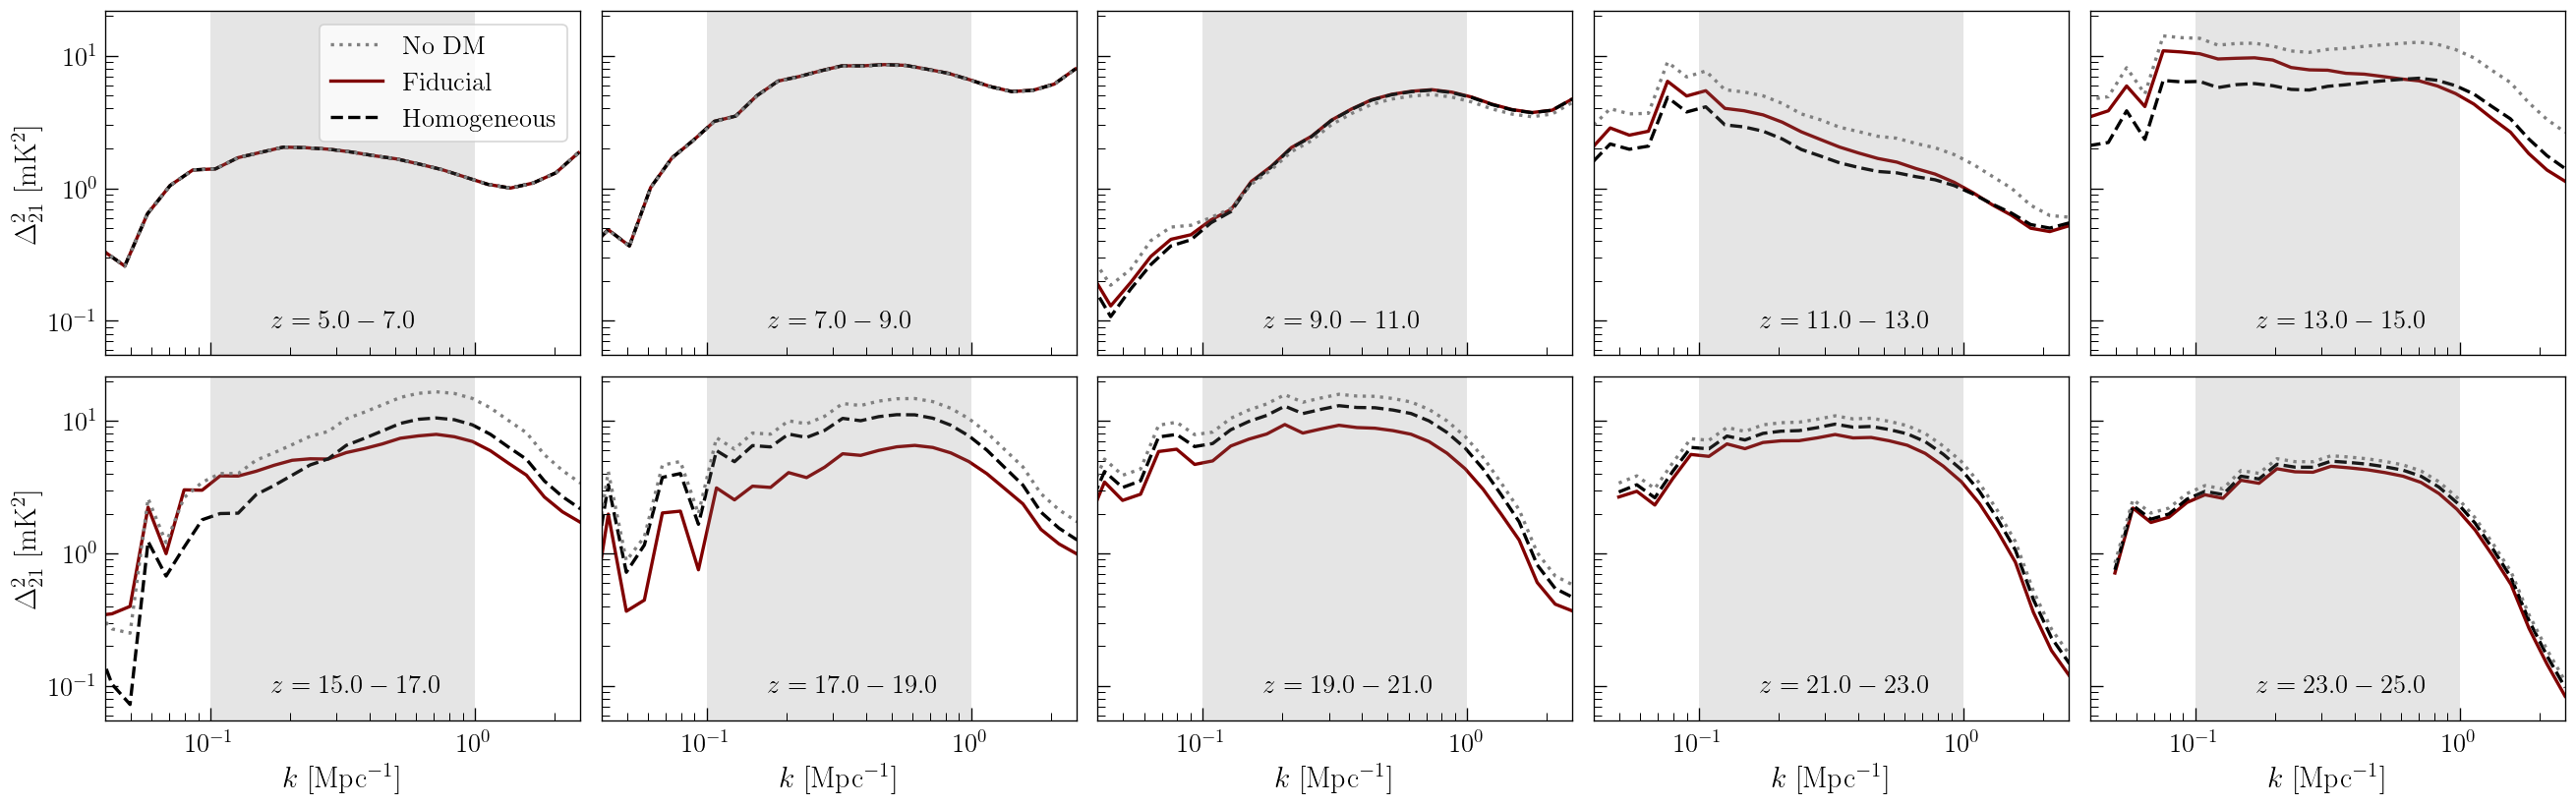

In [11]:
plt.rcParams['xtick.labelsize'] = 16  # Change x-axis label size
plt.rcParams['ytick.labelsize'] = 16  # Change y-axis label size

fig, axs = plt.subplots(2, 5, figsize=(22, 7), sharex=True, sharey=True)

z_start_s = np.linspace(5, 23, 10)

for i, ax in enumerate(axs.flat):
    z_start = z_start_s[i]
    z_end = z_start + 2

    ps_bkg = ps_bkg_s[i]
    ps_0 = ps_0_s[i]
    ps_1 = ps_1_s[i]

    ax.plot(ps_bkg["k"], ps_bkg["delta"], color="gray", ls=':', label='No DM', lw=2, zorder=2)
    ax.plot(ps_0["k"], ps_0["delta"], color="maroon", label='Fiducial', lw=2, zorder=0)
    ax.plot(ps_1["k"], ps_1["delta"], color="k", ls='--', label='Homogeneous', lw=2, zorder=1)

    ax.axvspan(0.1, 1, color='gray', ec='none', alpha=0.2)

    ax.text(0.35, 0.08, rf"$z={z_start:.1f}-{z_end:.1f}$", transform=ax.transAxes, fontsize=16)
    ax.set(xscale="log", yscale="log", xlim=(0.04, 2.5))
    ax.tick_params(axis='x', which='major', direction='in', length=8, pad=8)
    ax.tick_params(axis='y', which='major', direction='in', length=8, pad=4)
    ax.tick_params(axis='x', which='minor', direction='in', length=5, pad=8)
    ax.tick_params(axis='y', which='minor', direction='in', length=5, pad=4)


for i in range(5, 10):
    axs.flat[i].set_xlabel(r"$k$ [Mpc$^{-1}$]", fontsize=18)
for i in [0, 5]:
    axs.flat[i].set_ylabel(r"$\Delta_{21}^2$ [mK$^2$]", fontsize=18)

axs.flat[0].legend(fontsize=16, loc='upper right')

fig.tight_layout()
fig.savefig(f"plots/ps_small_inj.pdf", bbox_inches='tight')

In [ ]:
fig, axs = plt.subplots(4, 5, figsize = (20, 15), sharex = True, sharey = True)

chunk_inds = get_chunk_indices(lc_bkg, 20)
z_s = lc_bkg.lightcone_redshifts

for i, (ps, pss, psl) in enumerate(zip(ps_bkg, ps_small, ps_large)):
    ri, ci = np.unravel_index(i, axs.shape)
    ax = axs[ri, ci]

    ax.plot(ps['k'], ps['delta'], color='k', label='no DM' if i==0 else None)
    ax.plot(pss['k'], pss['delta'], color='b', label=r'$\tau=10^{28}$ s' if i==0 else None)
    ax.plot(psl['k'], psl['delta'], color='r', label=r'$\tau=10^{26}$ s' if i==0 else None)
    ax.set(xscale='log', yscale='log')

    ax.text(.1, .1, f'z={z_s[chunk_inds[i]]:.3f} - {z_s[chunk_inds[i+1]]:.3f}', transform=ax.transAxes, fontsize=18)

axs[0,0].legend()

for j in range(axs.shape[1]):
    axs[-1, j].set_xlabel('k [Mpc$^{-1}$]', fontsize = 22)
for i in range(axs.shape[0]):
    axs[i, 0].set_ylabel('$k^3 P(k)$', fontsize = 22)
    
fig.suptitle(r'$\chi\rightarrow\gamma\gamma, m_\chi=5$keV', fontsize=24)
fig.tight_layout();

In [ ]:
fig, axs = plt.subplots(4, 5, figsize = (20, 15), sharex = True, sharey = True)

chunk_inds = get_chunk_indices(lc_bkg, 20)
z_s = lc_bkg.lightcone_redshifts

for i, (ps, pss, psl) in enumerate(zip(ps_bkg, ps_small, ps_large)):
    ri, ci = np.unravel_index(i, axs.shape)
    ax = axs[ri, ci]
    ax.plot(psl['k'], psl['delta']-ps['delta'], color='r', label=r'$\tau=10^{26}$ s - no DM' if i==0 else None)
    ax.plot(psl['k'], -(psl['delta']-ps['delta']), color='r', ls=':')
    ax.plot(pss['k'], pss['delta']-ps['delta'], color='b', label=r'$\tau=10^{28}$ s - no DM' if i==0 else None)
    ax.plot(pss['k'], -(pss['delta']-ps['delta']), color='b', ls=':')
    ax.text(.1, .1, f'z={z_s[chunk_inds[i]]:.3f} - {z_s[chunk_inds[i+1]]:.3f}', transform=ax.transAxes, fontsize=18)

axs[0, 0].set(xscale='log', yscale='log', ylim=(1e-5, 1e2))
axs[0, 0].legend()

for j in range(axs.shape[1]):
    axs[-1, j].set_xlabel(r'k [Mpc$^{-1}$]', fontsize = 22)
for i in range(axs.shape[0]):
    axs[i, 0].set_ylabel(r'$\Delta k^3 P(k)$', fontsize = 22)
    
fig.suptitle('Difference', fontsize=20)
fig.tight_layout()

## What is the typical distance in which a photon deposite its energy?

In [12]:
with h5py.File('../data/cooling_rates/cfdepth.h5', 'r') as f:
    cfdepth = f['cfdepth'][()]
    rs_s = f['rs_s'][()]
    Ep_s = f['Ep_s'][()]

In [ ]:
cfdepth_interp = interpolate.RectBivariateSpline(rs_s, Ep_s, np.log10(cfdepth))
Ep = 2.5e3

cfdepth_arr = 10**cfdepth_interp(rs_s, np.full_like(rs_s, Ep), grid=False)
fig, ax = plt.subplots()
ax.plot(rs_s, cfdepth_arr)
ax.set(xscale='log', yscale='log')
ax.set(xlim=(5, 45), ylim=(0.8e3, 1e5))
ax.set(xlabel='Redshift', ylabel='cooling conformal length [Mpc]', title='2.5 keV photon');